In [4]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from model import loss
import tree
from data import rosetta_data_loader
from data import digs_data_loader
from experiments import train_se3_diffusion
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation

from omegaconf import OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

In [5]:
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(du)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/home/jyim/Projects/protein_diffusion_v2/experiments/train_se3_diffusion.py'>

In [13]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'digs'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 1
exp_conf.num_epoch = 10000
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False
exp_conf.normalize_pred_score = True

data_conf = conf.data
data_conf.digs.filtering.subset = 100
data_conf.digs.fraction_fb = 0.0
data_conf.digs.crop_len = None

diff_conf = conf.diffuser
diff_conf.diffuse_trans = False
diff_conf.diffuse_rots = True

# print(OmegaConf.to_yaml(conf))

In [14]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, train_sampler, valid_loader, valid_sampler = exp.create_digs_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

INFO: Number of model parameters 3488030
INFO: Using R^3 VP-SDE
INFO: Checkpoint not being saved.
INFO: Processing metadata.


Using cached IGSO3.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 4455.47it/s]
INFO: Cached data to ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_100.pkl
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_100.pkl


## Training

In [ ]:
step = 0
epoch = 0
train_losses = defaultdict(list)
log_losses = defaultdict(list)
latest_aux_data = []
sampled_ts = []

In [5]:
num_epochs = 100
def update_logs(x,y):
    for k in y:
        if 'loss' in k:
            x[k].append(y[k])
log_freq = 100

exp._model = exp._model.to(device)
exp._model.train()
while epoch < num_epochs:
    epoch += 1
    for train_features in train_loader:
        step += 1
        exp.step = step
        exp.num_epochs = epoch
        sampled_ts.append(train_features['t'])
        train_features = tree.map_structure(
            lambda x: x.to(device), train_features)
        _, aux_data = exp.update_fn(train_features)
        aux_data = tree.map_structure(du.move_to_np, aux_data)
        latest_aux_data.append(aux_data)
        update_logs(train_losses, aux_data)
        update_logs(log_losses, aux_data)
        if step == 1 or step % log_freq == 0:
            print_log = f'Step {step}: '
            for k,v in log_losses.items():
                print_log += f'{k}={np.mean(v):.4f} '
            print(print_log)
            log_losses = defaultdict(list)
            latest_aux_data = []

/home/jyim/Projects/protein_diffusion_v2/data/digs_data_loader.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'xyz': torch.tensor(centered_pos),


Step 1: total_loss=6.6217 rot_loss=3.4943 trans_loss=3.1274 
Step 100: total_loss=4.8991 rot_loss=3.1618 trans_loss=1.7372 
Step 200: total_loss=3.8141 rot_loss=3.0762 trans_loss=0.7378 
Step 300: total_loss=3.4523 rot_loss=2.7660 trans_loss=0.6863 
Step 400: total_loss=2.9318 rot_loss=2.2604 trans_loss=0.6714 
Step 500: total_loss=2.6459 rot_loss=1.9933 trans_loss=0.6526 
Step 600: total_loss=2.5460 rot_loss=1.9242 trans_loss=0.6218 
Step 700: total_loss=2.1959 rot_loss=1.6053 trans_loss=0.5906 
Step 800: total_loss=2.0097 rot_loss=1.3868 trans_loss=0.6228 
Step 900: total_loss=1.8763 rot_loss=1.2828 trans_loss=0.5936 
Step 1000: total_loss=1.7889 rot_loss=1.1936 trans_loss=0.5953 
Step 1100: total_loss=1.7489 rot_loss=1.1495 trans_loss=0.5995 
Step 1200: total_loss=1.6841 rot_loss=1.1017 trans_loss=0.5824 
Step 1300: total_loss=1.6739 rot_loss=1.1028 trans_loss=0.5711 
Step 1400: total_loss=1.6391 rot_loss=1.0862 trans_loss=0.5529 
Step 1500: total_loss=1.5992 rot_loss=1.0372 trans_l

Text(0, 0.5, 'Total loss')

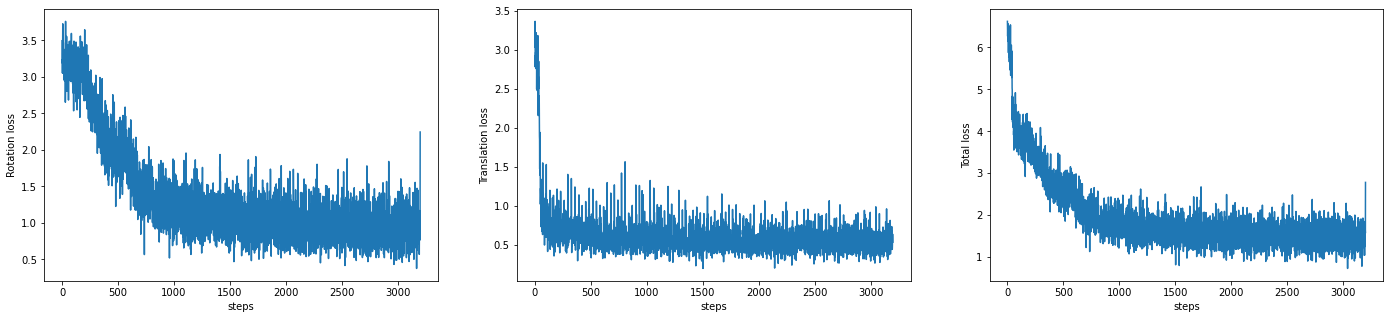

In [6]:
f, axes = plt.subplots(1, 3, figsize=[24, 5])

axes[0].plot(train_losses['rot_loss'])
axes[0].set_xlabel('steps')
axes[0].set_ylabel('Rotation loss')

axes[1].plot(train_losses['trans_loss'])
axes[1].set_xlabel('steps')
axes[1].set_ylabel('Translation loss')

axes[2].plot(train_losses['total_loss'])
axes[2].set_xlabel('steps')
axes[2].set_ylabel('Total loss')

In [ ]:
# du.write_checkpoint(
#     ckpt_path, self.model.state_dict(), self._conf)

## Data visualization

In [15]:
train_iter = iter(train_loader)
next_item = next(train_iter)
print(next_item['t'])

tensor([ 49,  25, 431, 116,  15, 375, 337, 154, 306,  33, 461, 455,  26, 246,
        376,   9])


/home/jyim/Projects/protein_diffusion_v2/data/digs_data_loader.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'xyz': torch.tensor(centered_pos),


In [17]:
# Rigid process function
scale_factor = conf.data.rosetta.scale_factor
bb_mask = next_item['res_mask'].bool()
def process_rigids(rigids, b_idx):
    np_rigids = du.move_to_np(rigids[b_idx][bb_mask[b_idx]])
    se3_vec = au.rigids_to_se3_vec(np_rigids, scale_factor=scale_factor)
    return np_rigids, se3_vec

In [20]:
# Visualize example
b_idx = 2
rigids_t, noisy_se3_vec = process_rigids(next_item['rigids_t'], b_idx)
rigids_0, gt_se3_vec = process_rigids(next_item['rigids_0'], b_idx)


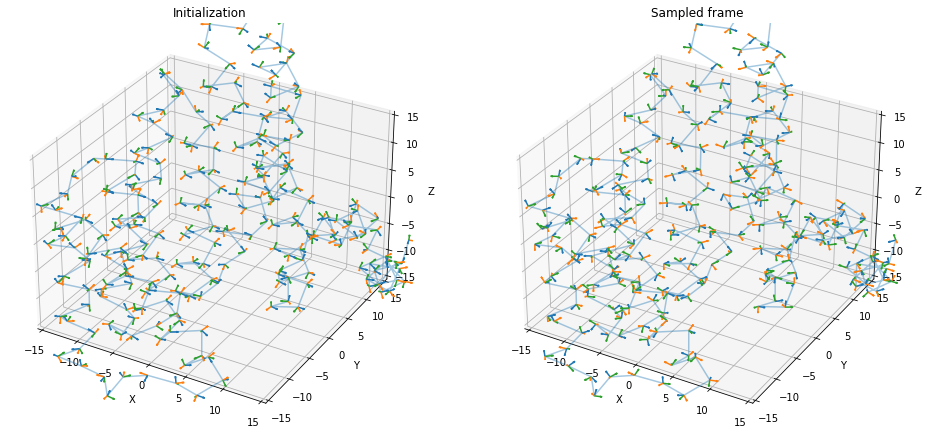

In [21]:
ax_lim = 15
f, axes = plt.subplots(1, 2, figsize=[16, 8], subplot_kw=dict(projection="3d"))
plotting.plot_se3(gt_se3_vec, ax=axes[0], title='Initialization', ax_lim=ax_lim)
plotting.plot_se3(noisy_se3_vec, ax=axes[1], title='Sampled frame', ax_lim=ax_lim)

In [101]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.device(i))

## Sampling

In [37]:
exp_diffuser = exp.diffuser

In [46]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

In [49]:
batch_idx = 1
data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']

num_res = res_mask.shape[0]
rigids_init = exp_diffuser.random_init(num_res).to_tensor_7()
rigids_init *= res_mask[:, None]
sample_feats = {
    'rigids_t': rigids_init,
    'res_mask': res_mask,
    'res_idx': res_idx,
    't': torch.tensor(exp_diffuser.num_t),
}
sample_feats = tree.map_structure(lambda x: x[None].to(device), sample_feats)

In [50]:
# Run reverse diffusion
reverse_steps = list(reversed(range(exp.diffuser.num_t)))
all_steps = [copy.deepcopy(sample_feats['rigids_t'])]
for t in reverse_steps[:-1]:
    sample_feats['t'] = (
        t * torch.ones_like(
            sample_feats['t'],
            device=device)).to(device)
    with torch.no_grad():
        model_out = exp.model(sample_feats)
    rot_score = model_out['rot_score']
    trans_noise = model_out['trans_score']
    sample_feats['rigids_t'] = exp.diffuser.reverse_sample(
        sample_feats['rigids_t'],
        rot_score,
        trans_noise,
        sample_feats['t'],
        torch.ones_like(sample_feats['res_mask']),
        add_noise=False
    )
    all_steps.append(copy.deepcopy(sample_feats['rigids_t']))

In [51]:
def viz_frames(rigids, mask, ax, scale_factor=10.0, title='', ax_lim=10.0):
    viz_mask = du.move_to_np(mask).astype(bool)
    frames = du.move_to_np(rigids)[viz_mask]
    se3_vec = au.rigids_to_se3_vec(frames, scale_factor=scale_factor)
    plotting.plot_se3(se3_vec, ax=ax, title=title, ax_lim=ax_lim)

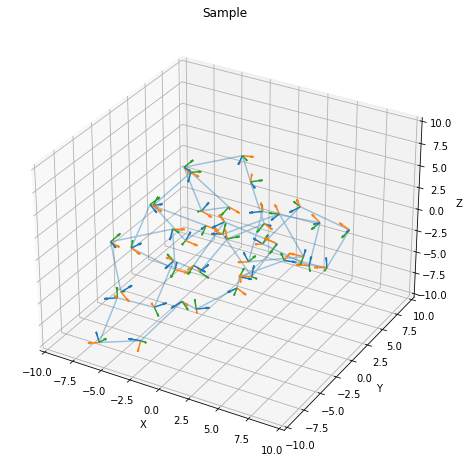

In [54]:
final_rigid = all_steps[-1][0]
f, axes = plt.subplots(1, 1, figsize=[8, 8], subplot_kw=dict(projection="3d"))
viz_frames(final_rigid, res_mask, axes, title='Sample', scale_factor=conf.data.rosetta.scale_factor)

In [7]:
# Calculate FAPE and Ca-RMSD metrics.
fape_loss = loss.rigids_fape(
    final_rigid,
    perturbed_final_rigid.to(final_rigid.device),
    res_mask.to(final_rigid.device),
    length_scale=scale_factor)
rmsd_loss, aligned_pred_ca, gt_ca, align_rot_mat, align_trans, reflection = loss.rigids_ca_rmsd(
    final_rigid,
    perturbed_final_rigid.to(final_rigid.device),
    res_mask.to(final_rigid.device),
    length_scale=scale_factor,
    return_align=True)
align_rot_euler = Rotation.from_matrix(align_rot_mat).as_euler('xyz', degrees=True)
print(f'FAPE: {fape_loss:2.4f}\nCa-RMSD: {rmsd_loss:2.4f}')
print(f'Alignment rotation: {align_rot_euler}\nAlignment translation: {align_trans[:,0]}\nAlignment reflection: {reflection}')


NameError: name 'final_rigid' is not defined

In [59]:
def compute_fape(pred_frame, target_frame, mask, length_scale=1.0):
    pred_frame = ru.Rigid.from_tensor_7(pred_frame)
    target_frame = ru.Rigid.from_tensor_7(target_frame)
    return loss.bb_fape_loss(
        pred_frames=pred_frame,
        target_frames=target_frame,
        frames_mask=mask,
        positions_mask=mask,
        pred_positions=pred_frame.get_trans(),
        target_positions=target_frame.get_trans(),
        l1_clamp_distance=10.0,
        length_scale=length_scale,
        eps=1e-4,
        ignore_nan=True,
    )

In [62]:
compute_fape(final_rigid, rigids_0.to(final_rigid.device), res_mask.to(final_rigid.device))

tensor(0.2081, device='cuda:0', dtype=torch.float64)